# Study of the physical dataset

In this notebook, we will study how different models perform on the physical dataset. Some of the models we will study are:
1. Non-supervised:
    - Isolation Forest (IF)
    - Local Outlier Factor (LOF)
2. Neural physicals:
    - DNN
    - LSTM
3. Supervised classifiers:
    - Decision Tree
    - Random Forest
    - XGBoost

First, let's import the necessary libraries.

In [3]:
from preprocess_data import get_HITL, clean_HITL, prepare_HTIL_physical_dataset, remove_physical_contextual_columns

from mlsecu.data_exploration_utils import (
    get_column_names,
    get_nb_of_dimensions,
    get_nb_of_rows,
    get_object_column_names,
    get_number_column_names,
)
from mlsecu.anomaly_detection_use_case import *
from mlsecu.data_preparation_utils import (
    get_one_hot_encoded_dataframe,
    remove_nan_through_mean_imputation,
)

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    matthews_corrcoef,
    balanced_accuracy_score,
    confusion_matrix,
)

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F

import tensorflow as tf
from tensorflow.keras.activations import swish, sigmoid, softmax

BASE_PATH = "../../data/"
random_state = 42
np.random.seed(random_state)
tf.random.set_seed(random_state)

# Load and prepare the dataset

We have defined multiple preprocessing functions in the `preprocessing.py` file. We will use them to load and prepare the dataset.

In [4]:
hitl_dict = get_HITL("../../data/HardwareInTheLoop/", small=False)
_, df_physical = clean_HITL(hitl_dict) # Clean-up helper function

print("Physical dataset shape: ", df_physical.shape)

Physical dataset shape:  (9206, 44)


In [5]:
df_physical_prepared, df_physical_labels = prepare_HTIL_physical_dataset(df_physical)
df_physical_prepared.head()

,time,tank_1,tank_2,tank_3,tank_4,tank_5,tank_6,tank_7,tank_8,pump_1,...,valv_13,valv_14,valv_15,valv_16,valv_17,valv_18,valv_19,valv_20,valv_21,valv_22
0,1.630780e+09,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1.630780e+09,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1.630780e+09,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1.630780e+09,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1.630780e+09,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [6]:
df_physical_labels.head()

,label_n,label,attack,new_labels
0,0.0,normal,1,2
1,0.0,normal,1,2
2,0.0,normal,1,2
3,0.0,normal,1,2
4,0.0,normal,1,2


# Models analysis

## 1. Non-supervised models

### a. Isolation Forest

As a first step, let's try default parameters for the Isolation Forest model.

In [7]:
df_physical_labels["label_n"].value_counts()

label_n
0.0    7747
1.0    1459
Name: count, dtype: int64

In [8]:
clf = IsolationForest(random_state=42)
y_pred = clf.fit_predict(df_physical_prepared)
if_outliers = df_physical_prepared[y_pred == -1].index.values.tolist()
len(if_outliers)

6177

In [9]:
df_physical_labels["label_n"].value_counts()

label_n
0.0    7747
1.0    1459
Name: count, dtype: int64

In [10]:
df_physical_labels.iloc[if_outliers]["label_n"].value_counts()

label_n
0.0    4997
1.0    1180
Name: count, dtype: int64

Out of the 6177 outliers found, 1180 are real anomalies (19%). This is not a great result knowing there are only 1459 outliers, let's see if we can do better with a fixed contamination rate.

In [11]:
val_counts_labels = df_physical_labels["label_n"].value_counts()
contamination_rate = val_counts_labels[1] / (val_counts_labels[0] + val_counts_labels[1])
contamination_rate

0.1584835976537041

In [12]:
clf = IsolationForest(n_estimators=100, n_jobs=-1, bootstrap=True, random_state=42, contamination=contamination_rate)
y_pred = clf.fit_predict(df_physical_prepared)
if_outliers_cr = df_physical_prepared[y_pred == -1].index.values.tolist()
len(if_outliers_cr)

1459

In [13]:
df_physical_labels.iloc[if_outliers_cr]["label_n"].value_counts()

label_n
0.0    940
1.0    519
Name: count, dtype: int64

With a fixed contamination rate, the model gets a total of 1459 outliers, out of which 519 are real anomalies (35.5%). This is a better result than with the default parameters and less false positives are found.

### b. Local Outlier Factor

In [14]:
clf = LocalOutlierFactor(n_neighbors=5)
y_pred = clf.fit_predict(df_physical_prepared)
lof_outliers = df_physical_prepared[y_pred == -1].index.values.tolist()
len(lof_outliers)

73

In [15]:
df_physical_labels.iloc[lof_outliers]["label_n"].value_counts()

label_n
0.0    48
1.0    25
Name: count, dtype: int64

We get terrible results.

## 2. Neural Networks

### a. DNN

We will use only some of the columns for the DNN model. We are removing contextual information such as the time. To make it easier to manipulate, we will merge back the labels with the predictions.

#### Binary classification

In [16]:
df = df_physical_prepared.copy()
df["label_n"] = df_physical_labels["label_n"]
df.head()

,time,tank_1,tank_2,tank_3,tank_4,tank_5,tank_6,tank_7,tank_8,pump_1,...,valv_14,valv_15,valv_16,valv_17,valv_18,valv_19,valv_20,valv_21,valv_22,label_n
0,1.630780e+09,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
1,1.630780e+09,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
2,1.630780e+09,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
3,1.630780e+09,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
4,1.630780e+09,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0.0


In [17]:
# convert bool columns to int
bool_cols = df.columns[df.dtypes == bool]
df[bool_cols] = df[bool_cols].astype(int)

# remove time column
if "Time" in df.columns:
    df.drop(columns=['Time'], inplace=True)

# Split data into train, validation, and test sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label_n'])
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42, stratify=train_df['label_n'])

# Separate features and target
X_train = train_df.drop(columns=['label_n'])
y_train = train_df['label_n']
X_val = val_df.drop(columns=['label_n'])
y_val = val_df['label_n']
X_test = test_df.drop(columns=['label_n'])
y_test = test_df['label_n']

# Normalize numerical features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

X_train.shape, X_val.shape, X_test.shape

((5891, 41), (1473, 41), (1842, 41))

In [18]:
X_train[0]

array([-1.8453872 ,  0.80077463,  1.38978397, -0.31653682, -0.80836626,
       -1.32533143, -0.10188866,  2.305095  , -0.92628226,  1.33125328,
        1.85997322,  0.        , -0.51106364,  1.29715255, -0.77736917,
        1.29761189, -0.77821244,  0.        , -0.75693134,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        , -1.2205967 , -1.2205967 ,
       -1.22016572, -0.82129835, -0.82129835, -0.82158816,  0.        ,
        0.91201897, -0.55179071,  0.        , -1.33567454,  0.        ,
       -0.91326873])

In [19]:
# Define the neural network model
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(X_train[0].shape[0],)),  # Input layer
    tf.keras.layers.Dense(1024, activation=swish),  # Hidden layer 1
    tf.keras.layers.Dense(256, activation=swish),   # Hidden layer 2
    tf.keras.layers.Dense(64, activation=swish),   # Hidden layer 3
    tf.keras.layers.Dense(1, activation=sigmoid)  # Output layer
])

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1024)              43008     
                                                                 
 dense_1 (Dense)             (None, 256)               262400    
                                                                 
 dense_2 (Dense)             (None, 64)                16448     
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 321,921
Trainable params: 321,921
Non-trainable params: 0
_________________________________________________________________


Let's define callbacks

In [20]:
# callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=6, verbose=1,
    mode='auto', baseline=None, restore_best_weights=True
)
reduce_on_plateau = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.1, patience=3, verbose=1,
    mode='auto', min_delta=0.0001, cooldown=0, min_lr=0
)

# Train the model
history = model.fit(X_train, y_train, 
                    epochs=40, 
                    batch_size=256, 
                    validation_data=(X_val, y_val),
                    callbacks=[early_stopping, reduce_on_plateau])

Epoch 1/40
24/24 [==============================] - 2s 15ms/step - loss: 0.4631 - accuracy: 0.8121 - val_loss: 0.3604 - val_accuracy: 0.8561 - lr: 0.0010
Epoch 2/40
24/24 [==============================] - 0s 6ms/step - loss: 0.3685 - accuracy: 0.8435 - val_loss: 0.3319 - val_accuracy: 0.8581 - lr: 0.0010
Epoch 3/40
24/24 [==============================] - 0s 6ms/step - loss: 0.3083 - accuracy: 0.8700 - val_loss: 0.2747 - val_accuracy: 0.8832 - lr: 0.0010
Epoch 4/40
24/24 [==============================] - 0s 7ms/step - loss: 0.2991 - accuracy: 0.8642 - val_loss: 0.2761 - val_accuracy: 0.8798 - lr: 0.0010
Epoch 5/40
24/24 [==============================] - 0s 9ms/step - loss: 0.2888 - accuracy: 0.8790 - val_loss: 0.2557 - val_accuracy: 0.8859 - lr: 0.0010
Epoch 6/40
24/24 [==============================] - 0s 9ms/step - loss: 0.2432 - accuracy: 0.8932 - val_loss: 0.2230 - val_accuracy: 0.9022 - lr: 0.0010
Epoch 7/40
24/24 [==============================] - 0s 8ms/step - loss: 0.2238 - 

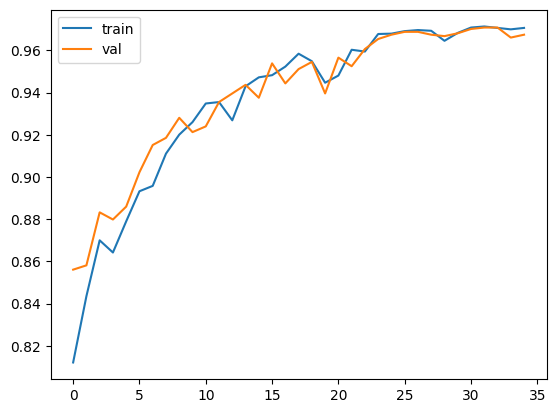

In [21]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.legend()
plt.show()

Evaluation on the test set:

In [22]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_accuracy * 100:.2f}%")

58/58 [==============================] - 0s 3ms/step - loss: 0.0974 - accuracy: 0.9663
Test accuracy: 96.63%


In [23]:
def plot_confusion_matrix(y_true, y_pred, title=None):
    fig, ax = plt.subplots(figsize=(6, 6))
    cm = confusion_matrix(y_true, y_pred)

    # normalize it
    cm = cm.astype(float) / cm.sum(axis=1)[:, np.newaxis]

    sns.heatmap(cm, annot=True, ax=ax, cmap="Blues")
    ax.set_ylabel("Actual")
    ax.set_xlabel("Predicted")
    if title:
        ax.set_title(title)
    plt.show()

58/58 [==============================] - 0s 2ms/step


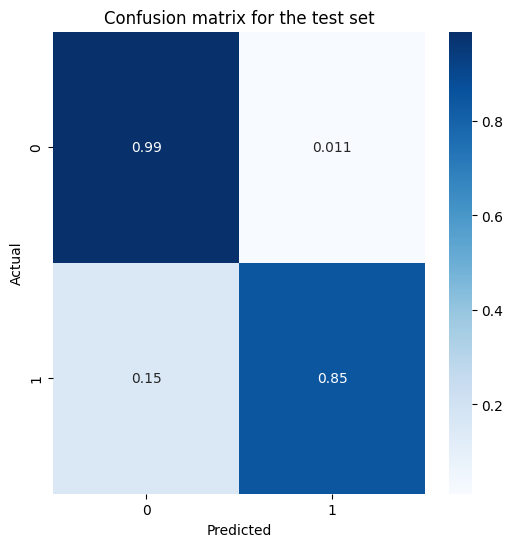

In [24]:
# Predict on test set
y_pred = model.predict(X_test)
y_pred = np.round(y_pred).astype(int).reshape(-1)

# Plot confusion matrix
plot_confusion_matrix(y_test, y_pred, title="Confusion matrix for the test set")

#### Multiclass classification

Now, we want to create an alternative DNN which will give us more precision on the type of attack. We will use the same architecture as before, but we will change the output layer to have 5 neurons, one for each type of attack.

In [25]:
df.drop(columns=['label_n'], inplace=True)
df["new_labels"] = df_physical_labels["new_labels"]
df["new_labels"].value_counts()

new_labels
2    7747
1     743
3     552
0     157
4       7
Name: count, dtype: int64

In [26]:
# let's remove the 4th class
df = df[df["new_labels"] != 4]

In [27]:
# Split data into train, validation, and test sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['new_labels'])
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42, stratify=train_df['new_labels'])

# Separate features and target
X_train = train_df.drop(columns=['new_labels'])
y_train = train_df['new_labels']
X_val = val_df.drop(columns=['new_labels'])
y_val = val_df['new_labels']
X_test = test_df.drop(columns=['new_labels'])
y_test = test_df['new_labels']

# Normalize numerical features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

X_train.shape, X_val.shape, X_test.shape

((5887, 41), (1472, 41), (1840, 41))

In [28]:
# Define the neural network model
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(X_train[0].shape[0],)),  # Input layer
    tf.keras.layers.Dense(1024, activation=swish),  # Hidden layer 1
    tf.keras.layers.Dense(256, activation=swish),   # Hidden layer 2
    tf.keras.layers.Dense(64, activation=swish),   # Hidden layer 3
    tf.keras.layers.Dense(5, activation=softmax)  # Output layer
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 1024)              43008     
                                                                 
 dense_5 (Dense)             (None, 256)               262400    
                                                                 
 dense_6 (Dense)             (None, 64)                16448     
                                                                 
 dense_7 (Dense)             (None, 5)                 325       
                                                                 
Total params: 322,181
Trainable params: 322,181
Non-trainable params: 0
_________________________________________________________________


In [29]:
history = model.fit(X_train, y_train, 
                    epochs=40, 
                    batch_size=256, 
                    validation_data=(X_val, y_val),
                    callbacks=[early_stopping, reduce_on_plateau])

Epoch 1/40


23/23 [==============================] - 1s 14ms/step - loss: 0.7696 - accuracy: 0.8101 - val_loss: 0.4767 - val_accuracy: 0.8499 - lr: 0.0010
Epoch 2/40
23/23 [==============================] - 0s 7ms/step - loss: 0.3868 - accuracy: 0.8724 - val_loss: 0.3498 - val_accuracy: 0.8709 - lr: 0.0010
Epoch 3/40
23/23 [==============================] - 0s 7ms/step - loss: 0.2993 - accuracy: 0.8823 - val_loss: 0.2842 - val_accuracy: 0.8893 - lr: 0.0010
Epoch 4/40
23/23 [==============================] - 0s 8ms/step - loss: 0.2389 - accuracy: 0.9052 - val_loss: 0.2402 - val_accuracy: 0.9076 - lr: 0.0010
Epoch 5/40
23/23 [==============================] - 0s 7ms/step - loss: 0.2016 - accuracy: 0.9183 - val_loss: 0.2035 - val_accuracy: 0.9151 - lr: 0.0010
Epoch 6/40
23/23 [==============================] - 0s 7ms/step - loss: 0.1754 - accuracy: 0.9290 - val_loss: 0.1886 - val_accuracy: 0.9171 - lr: 0.0010
Epoch 7/40
23/23 [==============================] - 0s 8ms/step - loss: 0.1521 - accuracy: 0

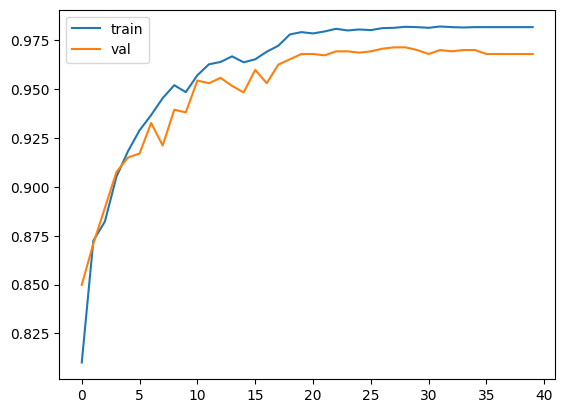

In [30]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.legend()
plt.show()

Evaluate on the test set:

In [31]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_accuracy * 100:.2f}%")

58/58 [==============================] - 0s 4ms/step - loss: 0.0737 - accuracy: 0.9755
Test accuracy: 97.55%


58/58 [==============================] - 0s 1ms/step


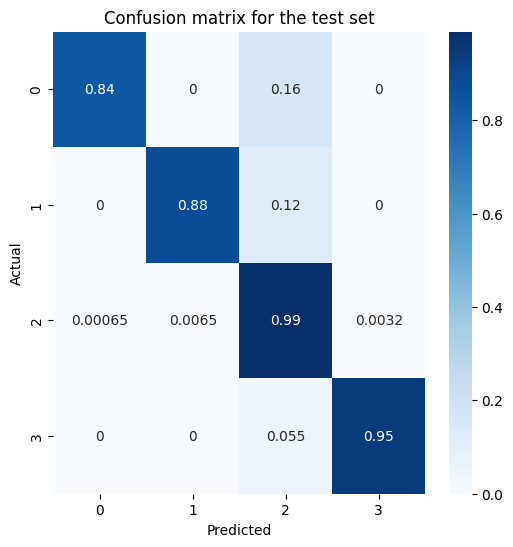

In [32]:
# Predict on test set
y_pred = model.predict(X_test)
y_pred = y_pred = np.argmax(y_pred, axis=1)

# Plot confusion matrix
plot_confusion_matrix(y_test, y_pred, title="Confusion matrix for the test set")

A very strange behavior is observed: the model is not able to predict any class other than 0 (one type of attack) and 2 (normal traffic). This is probably due to the fact that the dataset is very unbalanced, and the model is not able to learn the other classes.

In [33]:
# get recall, precision, f1-score, and accuracy
print("Recall: ", recall_score(y_test, y_pred, average='macro'))
print("Precision: ", precision_score(y_test, y_pred, average='macro'))
print("F1-score: ", f1_score(y_test, y_pred, average='macro'))
print("Accuracy: ", accuracy_score(y_test, y_pred))

Recall:  0.9132590682753056
Precision:  0.9569038387035992
F1-score:  0.9338290450856402
Accuracy:  0.9755434782608695


The model's metrics are really high, signifying a very good performance.

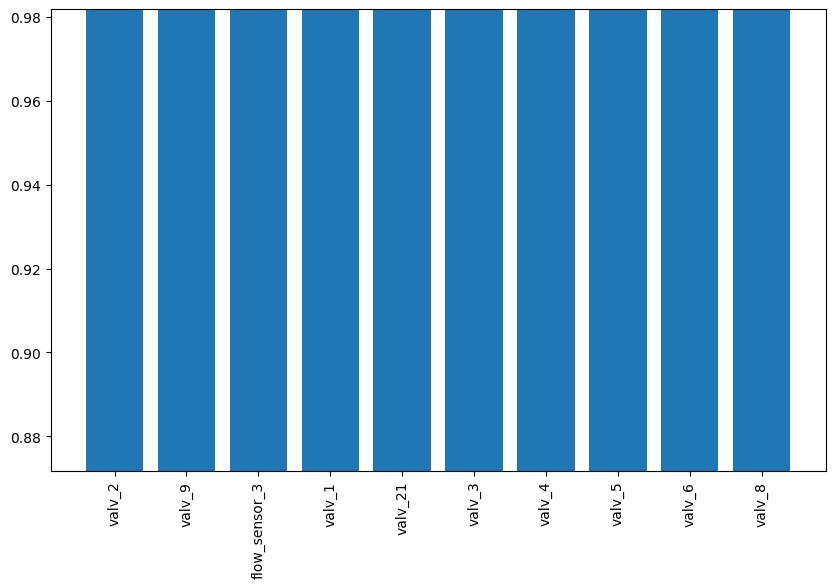

In [34]:
# feature importance for the network
def get_feature_importance(model, X_train, y_train):
    # get feature importance
    feature_importance = np.zeros(X_train.shape[1])
    for i in range(X_train.shape[1]):
        X_train_perm = X_train.copy()
        np.random.shuffle(X_train_perm[:, i])
        feature_importance[i] = model.evaluate(X_train_perm, y_train, verbose=0)[1]
    return feature_importance

feature_importance = get_feature_importance(model, X_train, y_train)

# plot top 5 features
topk = 10
top_features = np.argsort(feature_importance)[::-1][:topk]
plt.figure(figsize=(10, 6))
plt.bar(range(topk), feature_importance[top_features])
plt.xticks(range(topk), df.columns[top_features], rotation=90)
# scale down y-axis
plt.ylim(feature_importance.min(), feature_importance.max())
plt.show()

### b. LSTM

#### Binary classification

In [35]:
X_train, X_test, y_train, y_test = train_test_split(df_physical_prepared, df_physical_labels[["new_labels", "label_n"]], test_size=0.2, random_state=random_state)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=random_state)

In [36]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_val_scaled = scaler.transform(X_val)

Let's create a PyTorch dataset

In [37]:
class HITLDataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X).float()
        self.y = torch.tensor(y).long()

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


train_dataset = HITLDataset(X_train_scaled, y_train["label_n"].to_numpy())
test_dataset = HITLDataset(X_test_scaled, y_test["label_n"].to_numpy())
val_dataset = HITLDataset(X_val_scaled, y_val["label_n"].to_numpy())

# Create pytorch dataloader
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=True)

In [38]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out)
        return out
    
input_dim = X_train_scaled.shape[1]
output_dim = len(y_train["label_n"].unique())
hidden_dim = 32
model = LSTM(input_dim, hidden_dim, output_dim)
model

LSTM(
  (lstm): LSTM(41, 32, batch_first=True)
  (fc): Linear(in_features=32, out_features=2, bias=True)
)

In [39]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [40]:
from tqdm import tqdm

def train(model, train_loader, val_loader, criterion, optimizer):
    model.train()
    train_loss = 0
    train_acc = 0
    val_loss = 0
    val_acc = 0
    for X, y in tqdm(train_loader, total=len(train_loader)):
        optimizer.zero_grad()
        y_pred = model(X)
        loss = criterion(y_pred, y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_acc += (y_pred.argmax(1) == y).sum().item()

    model.eval()
    with torch.no_grad():
        for X, y in tqdm(val_loader, total=len(val_loader)):
            y_pred = model(X)
            loss = criterion(y_pred, y)
            val_loss += loss.item()
            val_acc += (y_pred.argmax(1) == y).sum().item()
    return train_loss / len(train_loader), train_acc / len(train_loader.dataset), val_loss / len(val_loader), val_acc / len(val_loader.dataset)

def test(model, test_loader, criterion):
    model.eval()
    test_loss = 0
    test_acc = 0
    y_pred_list = []
    y_true_list = []
    with torch.no_grad():
        for X, y in test_loader:
            y_pred = model(X)
            loss = criterion(y_pred, y)
            test_loss += loss.item()
            test_acc += (y_pred.argmax(1) == y).sum().item()
            y_pred_list.append(y_pred.argmax(1).cpu().numpy())
            y_true_list.append(y.cpu().numpy())
    return test_loss / len(test_loader), test_acc / len(test_loader.dataset)

100%|██████████| 47/47 [00:00<00:00, 888.64it/s]


Train loss: 0.4346, Train acc: 0.8465, Val loss: 0.3904, Val acc: 0.8418


100%|██████████| 47/47 [00:00<00:00, 746.02it/s]


Train loss: 0.3642, Train acc: 0.8564, Val loss: 0.3370, Val acc: 0.8615


100%|██████████| 47/47 [00:00<00:00, 810.38it/s]


Train loss: 0.3153, Train acc: 0.8722, Val loss: 0.2960, Val acc: 0.8771


100%|██████████| 47/47 [00:00<00:00, 779.68it/s]


Train loss: 0.2803, Train acc: 0.8861, Val loss: 0.2682, Val acc: 0.8832


100%|██████████| 47/47 [00:00<00:00, 1001.23it/s]


Train loss: 0.2559, Train acc: 0.8912, Val loss: 0.2410, Val acc: 0.9016


100%|██████████| 47/47 [00:00<00:00, 899.66it/s]


Train loss: 0.2338, Train acc: 0.9022, Val loss: 0.2223, Val acc: 0.9084


100%|██████████| 47/47 [00:00<00:00, 911.70it/s]


Train loss: 0.2163, Train acc: 0.9117, Val loss: 0.2119, Val acc: 0.9151


100%|██████████| 47/47 [00:00<00:00, 1017.90it/s]


Train loss: 0.2051, Train acc: 0.9167, Val loss: 0.2011, Val acc: 0.9172


100%|██████████| 47/47 [00:00<00:00, 1009.45it/s]


Train loss: 0.1921, Train acc: 0.9204, Val loss: 0.1871, Val acc: 0.9240


100%|██████████| 47/47 [00:00<00:00, 1233.35it/s]


Train loss: 0.1796, Train acc: 0.9245, Val loss: 0.1770, Val acc: 0.9267


100%|██████████| 47/47 [00:00<00:00, 1137.54it/s]


Train loss: 0.1752, Train acc: 0.9265, Val loss: 0.1792, Val acc: 0.9253


100%|██████████| 47/47 [00:00<00:00, 976.02it/s]


Train loss: 0.1678, Train acc: 0.9333, Val loss: 0.1695, Val acc: 0.9328


100%|██████████| 47/47 [00:00<00:00, 895.97it/s]


Train loss: 0.1627, Train acc: 0.9292, Val loss: 0.1619, Val acc: 0.9328


100%|██████████| 47/47 [00:00<00:00, 942.53it/s]


Train loss: 0.1579, Train acc: 0.9377, Val loss: 0.1569, Val acc: 0.9321


100%|██████████| 47/47 [00:00<00:00, 1143.00it/s]


Train loss: 0.1520, Train acc: 0.9372, Val loss: 0.1541, Val acc: 0.9341


100%|██████████| 47/47 [00:00<00:00, 1188.69it/s]


Train loss: 0.1441, Train acc: 0.9401, Val loss: 0.1464, Val acc: 0.9375


100%|██████████| 47/47 [00:00<00:00, 1218.68it/s]


Train loss: 0.1424, Train acc: 0.9384, Val loss: 0.1456, Val acc: 0.9423


100%|██████████| 47/47 [00:00<00:00, 1165.86it/s]


Train loss: 0.1382, Train acc: 0.9409, Val loss: 0.1461, Val acc: 0.9430


100%|██████████| 47/47 [00:00<00:00, 1205.20it/s]


Train loss: 0.1343, Train acc: 0.9425, Val loss: 0.1437, Val acc: 0.9443


100%|██████████| 47/47 [00:00<00:00, 1382.33it/s]


Train loss: 0.1303, Train acc: 0.9467, Val loss: 0.1546, Val acc: 0.9409


100%|██████████| 47/47 [00:00<00:00, 1266.30it/s]


Train loss: 0.1293, Train acc: 0.9448, Val loss: 0.1573, Val acc: 0.9382


100%|██████████| 47/47 [00:00<00:00, 1382.47it/s]


Train loss: 0.1245, Train acc: 0.9496, Val loss: 0.1301, Val acc: 0.9464


100%|██████████| 47/47 [00:00<00:00, 1305.22it/s]


Train loss: 0.1215, Train acc: 0.9492, Val loss: 0.1313, Val acc: 0.9423


100%|██████████| 47/47 [00:00<00:00, 1146.28it/s]


Train loss: 0.1213, Train acc: 0.9479, Val loss: 0.1278, Val acc: 0.9477


100%|██████████| 47/47 [00:00<00:00, 1197.73it/s]


Train loss: 0.1157, Train acc: 0.9506, Val loss: 0.1260, Val acc: 0.9464


100%|██████████| 47/47 [00:00<00:00, 1056.49it/s]


Train loss: 0.1162, Train acc: 0.9516, Val loss: 0.1218, Val acc: 0.9470


100%|██████████| 47/47 [00:00<00:00, 822.72it/s]


Train loss: 0.1148, Train acc: 0.9516, Val loss: 0.1185, Val acc: 0.9504


100%|██████████| 47/47 [00:00<00:00, 723.07it/s]


Train loss: 0.1109, Train acc: 0.9523, Val loss: 0.1180, Val acc: 0.9477


100%|██████████| 47/47 [00:00<00:00, 1372.59it/s]


Train loss: 0.1083, Train acc: 0.9560, Val loss: 0.1175, Val acc: 0.9470


100%|██████████| 47/47 [00:00<00:00, 1560.02it/s]


Train loss: 0.1072, Train acc: 0.9562, Val loss: 0.1128, Val acc: 0.9518


100%|██████████| 47/47 [00:00<00:00, 1300.33it/s]


Train loss: 0.1060, Train acc: 0.9569, Val loss: 0.1192, Val acc: 0.9498


100%|██████████| 47/47 [00:00<00:00, 1336.51it/s]


Train loss: 0.1046, Train acc: 0.9576, Val loss: 0.1109, Val acc: 0.9538


100%|██████████| 47/47 [00:00<00:00, 1449.60it/s]


Train loss: 0.1015, Train acc: 0.9584, Val loss: 0.1147, Val acc: 0.9518


100%|██████████| 47/47 [00:00<00:00, 1305.54it/s]


Train loss: 0.1028, Train acc: 0.9610, Val loss: 0.1125, Val acc: 0.9566


100%|██████████| 47/47 [00:00<00:00, 1113.30it/s]


Train loss: 0.1014, Train acc: 0.9584, Val loss: 0.1056, Val acc: 0.9518


100%|██████████| 47/47 [00:00<00:00, 563.25it/s]


Train loss: 0.0978, Train acc: 0.9615, Val loss: 0.1108, Val acc: 0.9532


100%|██████████| 47/47 [00:00<00:00, 1265.14it/s]


Train loss: 0.0957, Train acc: 0.9632, Val loss: 0.1065, Val acc: 0.9586


100%|██████████| 47/47 [00:00<00:00, 1198.40it/s]


Train loss: 0.0941, Train acc: 0.9632, Val loss: 0.1090, Val acc: 0.9559


100%|██████████| 47/47 [00:00<00:00, 1236.77it/s]


Train loss: 0.0936, Train acc: 0.9649, Val loss: 0.1034, Val acc: 0.9525


100%|██████████| 47/47 [00:00<00:00, 1264.57it/s]


Train loss: 0.0930, Train acc: 0.9606, Val loss: 0.1015, Val acc: 0.9647


100%|██████████| 47/47 [00:00<00:00, 1143.00it/s]


Train loss: 0.0924, Train acc: 0.9632, Val loss: 0.0975, Val acc: 0.9593


100%|██████████| 47/47 [00:00<00:00, 1052.41it/s]


Train loss: 0.0909, Train acc: 0.9618, Val loss: 0.1042, Val acc: 0.9606


100%|██████████| 47/47 [00:00<00:00, 1069.89it/s]


Train loss: 0.0889, Train acc: 0.9674, Val loss: 0.1060, Val acc: 0.9593


100%|██████████| 47/47 [00:00<00:00, 815.85it/s]


Train loss: 0.0876, Train acc: 0.9654, Val loss: 0.0960, Val acc: 0.9640


100%|██████████| 47/47 [00:00<00:00, 1382.31it/s]


Train loss: 0.0871, Train acc: 0.9660, Val loss: 0.1028, Val acc: 0.9579


100%|██████████| 47/47 [00:00<00:00, 1382.34it/s]


Train loss: 0.0861, Train acc: 0.9674, Val loss: 0.0998, Val acc: 0.9599


100%|██████████| 47/47 [00:00<00:00, 1227.28it/s]


Train loss: 0.0854, Train acc: 0.9679, Val loss: 0.1013, Val acc: 0.9579


100%|██████████| 47/47 [00:00<00:00, 1053.51it/s]


Train loss: 0.0821, Train acc: 0.9706, Val loss: 0.0958, Val acc: 0.9613


100%|██████████| 47/47 [00:00<00:00, 1380.43it/s]


Train loss: 0.0831, Train acc: 0.9706, Val loss: 0.0962, Val acc: 0.9633


100%|██████████| 47/47 [00:00<00:00, 1375.49it/s]


Train loss: 0.0833, Train acc: 0.9681, Val loss: 0.1042, Val acc: 0.9606


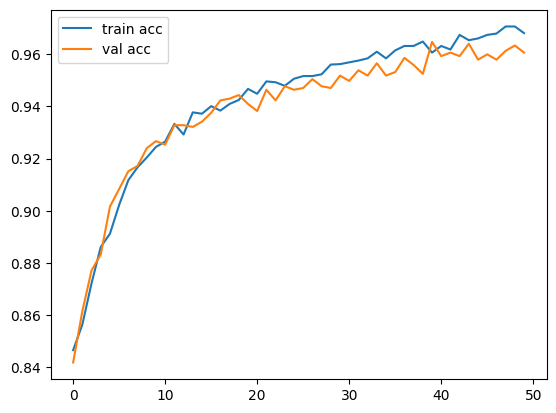

In [41]:
EPOCHS = 50
train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []

for _ in range(EPOCHS):
    train_loss, train_acc, val_loss, val_acc = train(model, train_loader, val_loader, criterion, optimizer)
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)
    print(f"Train loss: {train_loss:.4f}, Train acc: {train_acc:.4f}, Val loss: {val_loss:.4f}, Val acc: {val_acc:.4f}")

# Plot train loss and accuracy
plt.plot(train_acc_list, label="train acc")
plt.plot(val_acc_list, label="val acc")
plt.legend()
plt.show()

In [42]:
test_loss, test_acc = test(model, test_loader, criterion)
print(f"Test loss: {test_loss:.4f}, Test acc: {test_acc:.4f}")

Test loss: 0.0867, Test acc: 0.9609


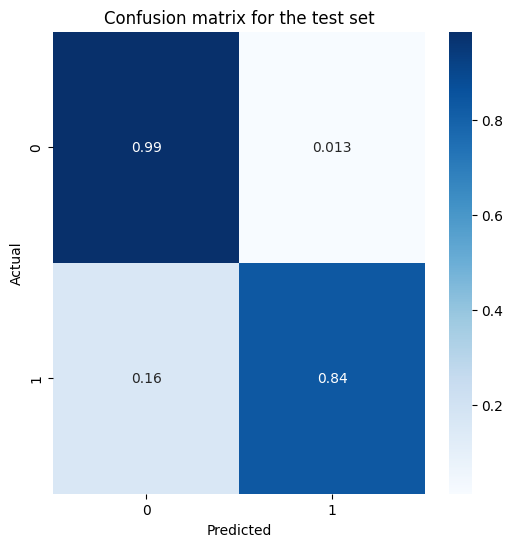

In [43]:
# Predict on test set
y_pred_list = []
y_true_list = []
with torch.no_grad():
    for X, y in test_loader:
        y_pred = model(X)
        y_pred_list.append(y_pred.argmax(1).cpu().numpy())
        y_true_list.append(y.cpu().numpy())

y_pred = np.concatenate(y_pred_list)
y_true = np.concatenate(y_true_list)

# Plot confusion matrix
plot_confusion_matrix(y_true, y_pred, title="Confusion matrix for the test set")

#### Multiclass classification

In [44]:
train_dataset = HITLDataset(X_train_scaled, y_train["new_labels"].to_numpy())
test_dataset = HITLDataset(X_test_scaled, y_test["new_labels"].to_numpy())
val_dataset = HITLDataset(X_val_scaled, y_val["new_labels"].to_numpy())

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=True)

In [45]:
input_dim = X_train_scaled.shape[1]
output_dim = len(y_train["new_labels"].unique())
hidden_dim = 32
model = LSTM(input_dim, hidden_dim, output_dim)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

100%|██████████| 47/47 [00:00<00:00, 1108.36it/s]


Train loss: 0.8568, Train acc: 0.7540, Val loss: 0.6234, Val acc: 0.8384


100%|██████████| 47/47 [00:00<00:00, 1100.42it/s]


Train loss: 0.5629, Train acc: 0.8469, Val loss: 0.5764, Val acc: 0.8377


100%|██████████| 47/47 [00:00<00:00, 1119.58it/s]


Train loss: 0.5010, Train acc: 0.8491, Val loss: 0.4775, Val acc: 0.8486


100%|██████████| 47/47 [00:00<00:00, 1218.63it/s]


Train loss: 0.4429, Train acc: 0.8571, Val loss: 0.4296, Val acc: 0.8568


100%|██████████| 47/47 [00:00<00:00, 1146.93it/s]


Train loss: 0.4036, Train acc: 0.8664, Val loss: 0.4018, Val acc: 0.8588


100%|██████████| 47/47 [00:00<00:00, 1188.03it/s]


Train loss: 0.3657, Train acc: 0.8779, Val loss: 0.3595, Val acc: 0.8758


100%|██████████| 47/47 [00:00<00:00, 1118.97it/s]


Train loss: 0.3384, Train acc: 0.8817, Val loss: 0.3306, Val acc: 0.8873


100%|██████████| 47/47 [00:00<00:00, 1208.25it/s]


Train loss: 0.3150, Train acc: 0.8836, Val loss: 0.3070, Val acc: 0.8880


100%|██████████| 47/47 [00:00<00:00, 1241.92it/s]


Train loss: 0.2961, Train acc: 0.8892, Val loss: 0.3005, Val acc: 0.8900


100%|██████████| 47/47 [00:00<00:00, 1262.48it/s]


Train loss: 0.2802, Train acc: 0.8946, Val loss: 0.2764, Val acc: 0.9002


100%|██████████| 47/47 [00:00<00:00, 1107.40it/s]


Train loss: 0.2645, Train acc: 0.8983, Val loss: 0.2635, Val acc: 0.9056


100%|██████████| 47/47 [00:00<00:00, 1237.31it/s]


Train loss: 0.2497, Train acc: 0.9056, Val loss: 0.2505, Val acc: 0.9165


100%|██████████| 47/47 [00:00<00:00, 1310.75it/s]


Train loss: 0.2387, Train acc: 0.9094, Val loss: 0.2417, Val acc: 0.9097


100%|██████████| 47/47 [00:00<00:00, 1265.78it/s]


Train loss: 0.2277, Train acc: 0.9155, Val loss: 0.2309, Val acc: 0.9151


100%|██████████| 47/47 [00:00<00:00, 979.26it/s]


Train loss: 0.2215, Train acc: 0.9184, Val loss: 0.2226, Val acc: 0.9226


100%|██████████| 47/47 [00:00<00:00, 1186.94it/s]


Train loss: 0.2095, Train acc: 0.9226, Val loss: 0.2288, Val acc: 0.9294


100%|██████████| 47/47 [00:00<00:00, 1137.66it/s]


Train loss: 0.2033, Train acc: 0.9277, Val loss: 0.2027, Val acc: 0.9287


100%|██████████| 47/47 [00:00<00:00, 950.61it/s]


Train loss: 0.1955, Train acc: 0.9284, Val loss: 0.1952, Val acc: 0.9328


100%|██████████| 47/47 [00:00<00:00, 944.52it/s]


Train loss: 0.1873, Train acc: 0.9336, Val loss: 0.2004, Val acc: 0.9328


100%|██████████| 47/47 [00:00<00:00, 1209.06it/s]


Train loss: 0.1810, Train acc: 0.9357, Val loss: 0.1778, Val acc: 0.9362


100%|██████████| 47/47 [00:00<00:00, 1301.44it/s]


Train loss: 0.1794, Train acc: 0.9352, Val loss: 0.1782, Val acc: 0.9321


100%|██████████| 47/47 [00:00<00:00, 1438.67it/s]


Train loss: 0.1739, Train acc: 0.9380, Val loss: 0.1708, Val acc: 0.9382


100%|██████████| 47/47 [00:00<00:00, 1231.17it/s]


Train loss: 0.1705, Train acc: 0.9401, Val loss: 0.1655, Val acc: 0.9403


100%|██████████| 47/47 [00:00<00:00, 810.30it/s]


Train loss: 0.1600, Train acc: 0.9413, Val loss: 0.1677, Val acc: 0.9382


100%|██████████| 47/47 [00:00<00:00, 1382.35it/s]


Train loss: 0.1556, Train acc: 0.9453, Val loss: 0.1628, Val acc: 0.9403


100%|██████████| 47/47 [00:00<00:00, 1424.19it/s]


Train loss: 0.1539, Train acc: 0.9423, Val loss: 0.1559, Val acc: 0.9416


100%|██████████| 47/47 [00:00<00:00, 902.22it/s]


Train loss: 0.1486, Train acc: 0.9467, Val loss: 0.1525, Val acc: 0.9396


100%|██████████| 47/47 [00:00<00:00, 968.86it/s]


Train loss: 0.1457, Train acc: 0.9452, Val loss: 0.1504, Val acc: 0.9504


100%|██████████| 47/47 [00:00<00:00, 1111.46it/s]


Train loss: 0.1421, Train acc: 0.9492, Val loss: 0.1440, Val acc: 0.9491


100%|██████████| 47/47 [00:00<00:00, 1132.00it/s]


Train loss: 0.1369, Train acc: 0.9492, Val loss: 0.1458, Val acc: 0.9450


100%|██████████| 47/47 [00:00<00:00, 698.55it/s]


Train loss: 0.1352, Train acc: 0.9504, Val loss: 0.1409, Val acc: 0.9484


100%|██████████| 47/47 [00:00<00:00, 1175.04it/s]


Train loss: 0.1324, Train acc: 0.9511, Val loss: 0.1387, Val acc: 0.9443


100%|██████████| 47/47 [00:00<00:00, 1146.38it/s]


Train loss: 0.1291, Train acc: 0.9508, Val loss: 0.1382, Val acc: 0.9470


100%|██████████| 47/47 [00:00<00:00, 1236.84it/s]


Train loss: 0.1265, Train acc: 0.9542, Val loss: 0.1372, Val acc: 0.9457


100%|██████████| 47/47 [00:00<00:00, 1232.34it/s]


Train loss: 0.1230, Train acc: 0.9545, Val loss: 0.1320, Val acc: 0.9545


100%|██████████| 47/47 [00:00<00:00, 1189.61it/s]


Train loss: 0.1229, Train acc: 0.9543, Val loss: 0.1268, Val acc: 0.9566


100%|██████████| 47/47 [00:00<00:00, 1119.09it/s]


Train loss: 0.1195, Train acc: 0.9572, Val loss: 0.1247, Val acc: 0.9532


100%|██████████| 47/47 [00:00<00:00, 1118.71it/s]


Train loss: 0.1178, Train acc: 0.9569, Val loss: 0.1275, Val acc: 0.9491


100%|██████████| 47/47 [00:00<00:00, 1146.30it/s]


Train loss: 0.1159, Train acc: 0.9577, Val loss: 0.1368, Val acc: 0.9518


100%|██████████| 47/47 [00:00<00:00, 1237.18it/s]


Train loss: 0.1141, Train acc: 0.9562, Val loss: 0.1468, Val acc: 0.9532


100%|██████████| 47/47 [00:00<00:00, 1146.31it/s]


Train loss: 0.1103, Train acc: 0.9608, Val loss: 0.1262, Val acc: 0.9532


100%|██████████| 47/47 [00:00<00:00, 1270.17it/s]


Train loss: 0.1120, Train acc: 0.9584, Val loss: 0.1143, Val acc: 0.9559


100%|██████████| 47/47 [00:00<00:00, 1236.95it/s]


Train loss: 0.1070, Train acc: 0.9611, Val loss: 0.1177, Val acc: 0.9538


100%|██████████| 47/47 [00:00<00:00, 1328.33it/s]


Train loss: 0.1066, Train acc: 0.9610, Val loss: 0.1121, Val acc: 0.9586


100%|██████████| 47/47 [00:00<00:00, 1407.48it/s]


Train loss: 0.1060, Train acc: 0.9616, Val loss: 0.1165, Val acc: 0.9525


100%|██████████| 47/47 [00:00<00:00, 1342.89it/s]


Train loss: 0.1027, Train acc: 0.9630, Val loss: 0.1195, Val acc: 0.9552


100%|██████████| 47/47 [00:00<00:00, 1418.09it/s]


Train loss: 0.1010, Train acc: 0.9620, Val loss: 0.1107, Val acc: 0.9640


100%|██████████| 47/47 [00:00<00:00, 1236.76it/s]


Train loss: 0.1008, Train acc: 0.9613, Val loss: 0.1098, Val acc: 0.9559


100%|██████████| 47/47 [00:00<00:00, 1227.07it/s]


Train loss: 0.0985, Train acc: 0.9635, Val loss: 0.1195, Val acc: 0.9511


100%|██████████| 47/47 [00:00<00:00, 1332.52it/s]


Train loss: 0.0977, Train acc: 0.9660, Val loss: 0.1124, Val acc: 0.9552


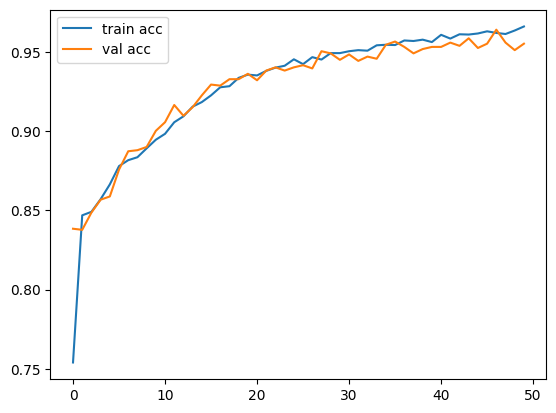

In [46]:
EPOCHS = 50
train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []

for _ in range(EPOCHS):
    train_loss, train_acc, val_loss, val_acc = train(model, train_loader, val_loader, criterion, optimizer)
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)
    print(f"Train loss: {train_loss:.4f}, Train acc: {train_acc:.4f}, Val loss: {val_loss:.4f}, Val acc: {val_acc:.4f}")

# Plot train loss and accuracy
plt.plot(train_acc_list, label="train acc")
plt.plot(val_acc_list, label="val acc")
plt.legend()
plt.show()

In [47]:
test_loss, test_acc = test(model, test_loader, criterion)
print(f"Test loss: {test_loss:.4f}, Test acc: {test_acc:.4f}")

Test loss: 0.1075, Test acc: 0.9566


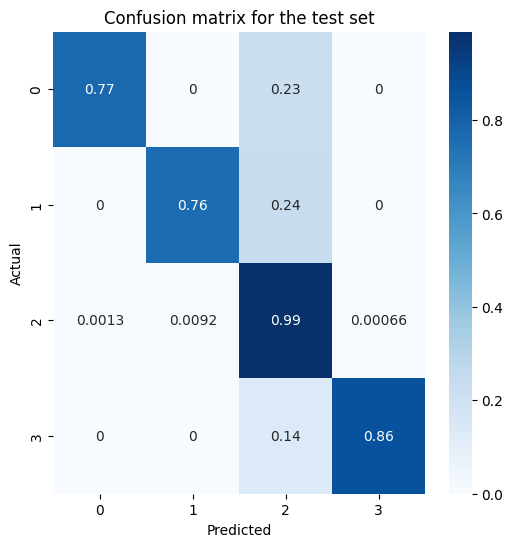

In [48]:
# Predict on test set
y_pred_list = []
y_true_list = []
with torch.no_grad():
    for X, y in test_loader:
        y_pred = model(X)
        y_pred_list.append(y_pred.argmax(1).cpu().numpy())
        y_true_list.append(y.cpu().numpy())

y_pred = np.concatenate(y_pred_list)
y_true = np.concatenate(y_true_list)

# Plot confusion matrix
plot_confusion_matrix(y_true, y_pred, title="Confusion matrix for the test set")

## 3. Supervised classifiers

### a. Decision Tree

#### Multiclass classification

We will not use the Decision Tree for the binary classification, as we want to focus on the features importance.

In [49]:
X_train, X_test, y_train, y_test = train_test_split(df_physical_prepared, df_physical_labels[["new_labels", "label_n"]], test_size=0.2, random_state=random_state)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((7364, 41), (1842, 41), (7364, 2), (1842, 2))

Define the model with empirical parameters

In [50]:
params = {
    'max_depth': 8,
    'criterion': 'gini',
    'splitter': 'best',
    'random_state': random_state
}

clf = DecisionTreeClassifier(**params)

In [51]:
pipeline = make_pipeline(
    StandardScaler(),
    clf
)

pipeline.fit(X_train, y_train["new_labels"])

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(max_depth=8, random_state=42))])

In [52]:
preds = pipeline.predict(X_test)

In [53]:
print("Accuracy: ", accuracy_score(y_test["new_labels"], preds.round()))
print("Recall: ", recall_score(y_test["new_labels"], preds.round(), average="macro"))
print("F1: ", f1_score(y_test["new_labels"], preds.round(), average="macro"))
print("MCC: ", matthews_corrcoef(y_test["new_labels"], preds.round()))
print("Balanced accuracy: ", balanced_accuracy_score(y_test["new_labels"], preds.round()))

Accuracy:  0.9467969598262758
Recall:  0.6881698674841034
F1:  0.7326219385662255
MCC:  0.8133878482930105
Balanced accuracy:  0.6881698674841034


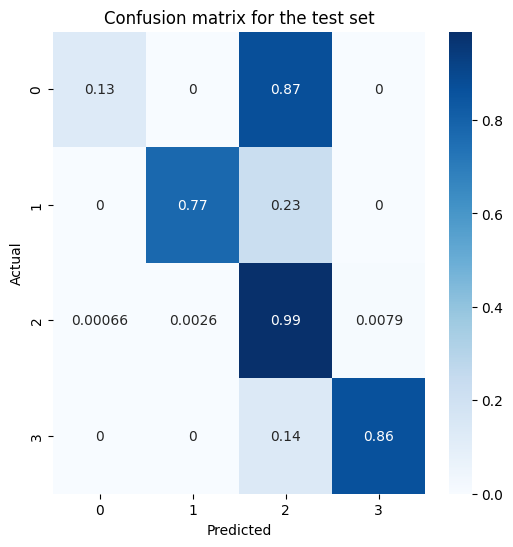

In [54]:
plot_confusion_matrix(y_test["new_labels"], preds.round(), title="Confusion matrix for the test set")

Let's see which feature is the most important

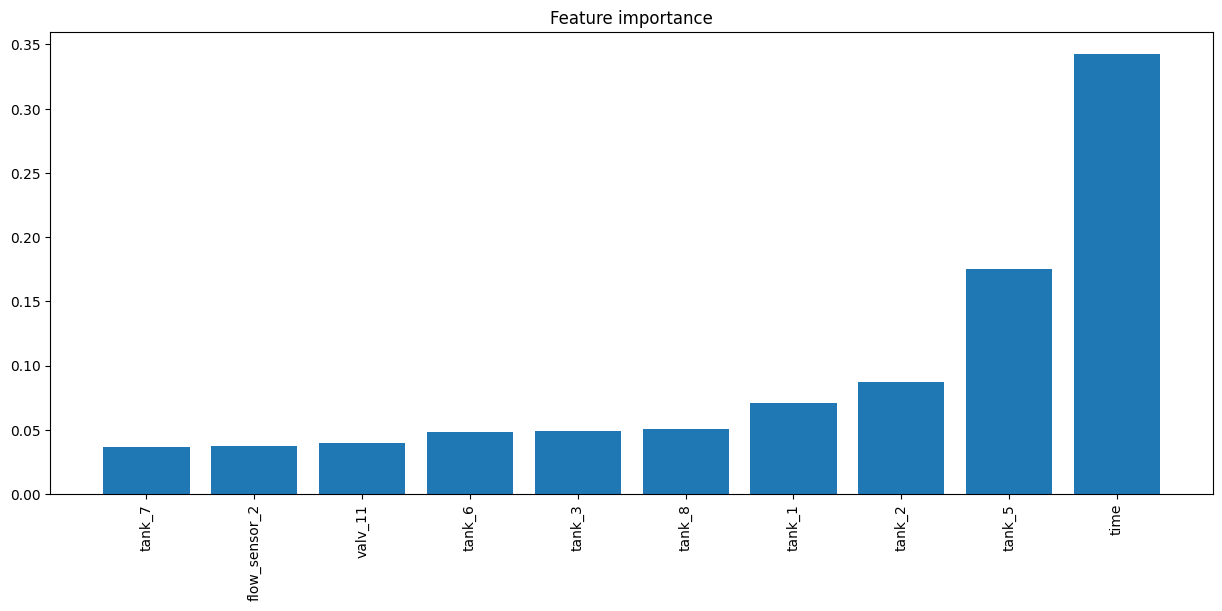

In [55]:
def plot_feature_importance(clf):
    importance = clf.feature_importances_
    # keep 10 most important features
    idx = np.argsort(importance)[-10:]
    importance = importance[idx]

    # plot feature importance
    plt.figure(figsize=(15, 6))
    plt.title("Feature importance")
    plt.bar([x for x in range(len(importance))], importance)
    plt.xticks([x for x in range(len(importance))], X_train.columns[idx], rotation='vertical')
    plt.show()

plot_feature_importance(clf)

#### Without contextual information

In [56]:
df_physical_no_context = remove_physical_contextual_columns(df_physical)
df_physical_no_context

,tank_1,tank_2,tank_3,tank_4,tank_5,tank_6,tank_7,tank_8,pump_1,pump_2,...,valv_16,valv_17,valv_18,valv_19,valv_20,valv_21,valv_22,label_n,label,attack
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.0,normal,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.0,normal,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.0,normal,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.0,normal,1
4,0,0,0,0,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0.0,normal,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9201,4,1037,7,452,300,432,80,0,1,0,...,0,0,0,0,1,0,0,0.0,normal,0
9202,3,1059,7,439,296,431,88,0,1,0,...,0,0,0,0,1,0,0,0.0,normal,0
9203,4,1091,8,429,291,431,96,0,1,0,...,0,0,0,0,1,0,0,0.0,normal,0
9204,4,1131,8,417,288,421,96,0,1,0,...,0,0,0,0,1,0,0,0.0,normal,0


In [57]:
df_physical_prepared, df_physical_labels = prepare_HTIL_physical_dataset(df_physical_no_context)
df_physical_prepared.head()

,tank_1,tank_2,tank_3,tank_4,tank_5,tank_6,tank_7,tank_8,pump_1,pump_2,...,valv_13,valv_14,valv_15,valv_16,valv_17,valv_18,valv_19,valv_20,valv_21,valv_22
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0


In [58]:
X_train, X_test, y_train, y_test = train_test_split(df_physical_prepared, df_physical_labels[["new_labels", "label_n"]], test_size=0.2, random_state=random_state)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((7364, 40), (1842, 40), (7364, 2), (1842, 2))

In [59]:
params = {
    'max_depth': 8,
    'criterion': 'gini',
    'splitter': 'best',
    'random_state': random_state
}

clf = DecisionTreeClassifier(**params)

In [60]:
pipeline = make_pipeline(
    StandardScaler(),
    clf
)

pipeline.fit(X_train, y_train["new_labels"])

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(max_depth=8, random_state=42))])

In [61]:
preds = pipeline.predict(X_test)

In [62]:
print("Accuracy: ", accuracy_score(y_test["new_labels"], preds.round()))
print("Recall: ", recall_score(y_test["new_labels"], preds.round(), average="macro"))
print("F1: ", f1_score(y_test["new_labels"], preds.round(), average="macro"))
print("MCC: ", matthews_corrcoef(y_test["new_labels"], preds.round()))
print("Balanced accuracy: ", balanced_accuracy_score(y_test["new_labels"], preds.round()))

Accuracy:  0.9098805646036916
Recall:  0.6005756884527672
F1:  0.6716904212164876
MCC:  0.6660129300122372
Balanced accuracy:  0.6005756884527672


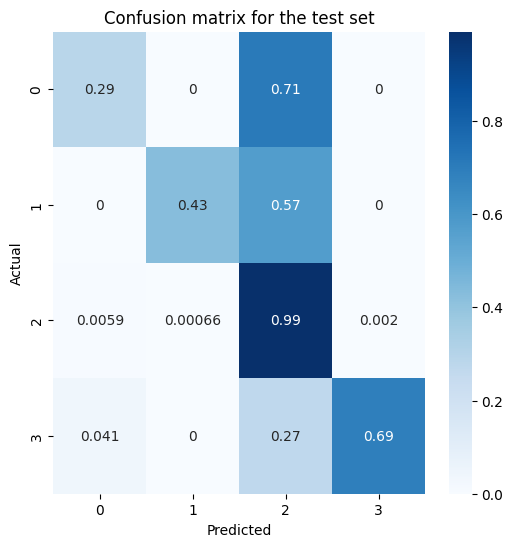

In [63]:
plot_confusion_matrix(y_test["new_labels"], preds.round(), title="Confusion matrix for the test set")

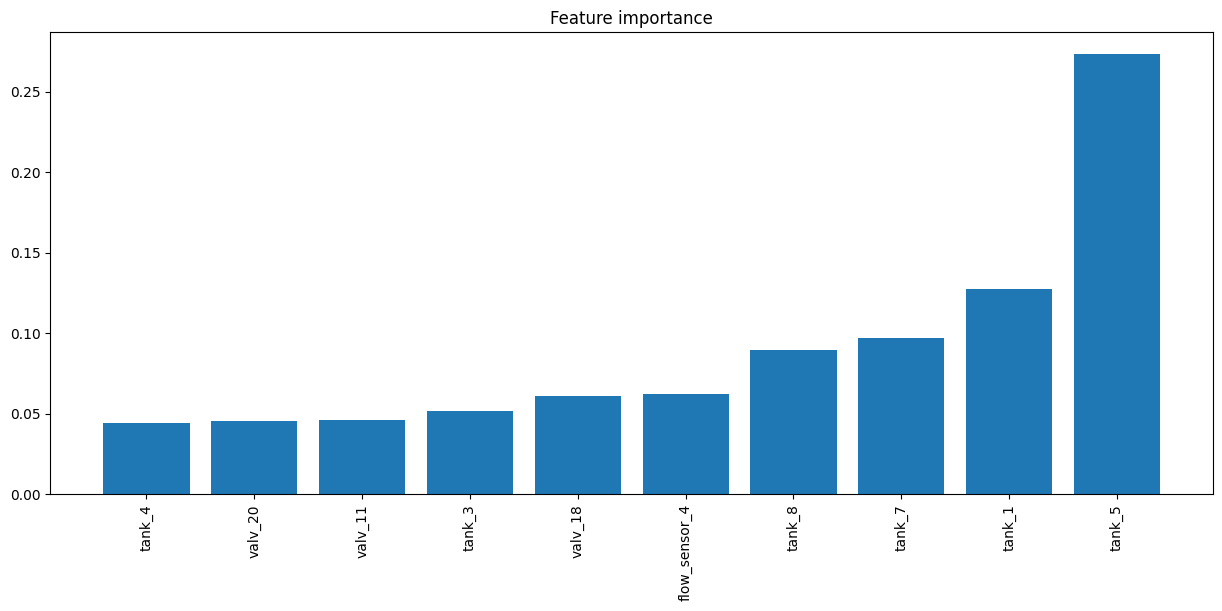

In [64]:
plot_feature_importance(clf)

### b. Random Forest

Accuracy:  0.9250814332247557
Recall:  0.6057742776627721
F1:  0.6777597889340983
MCC:  0.7300372233517338
Balanced accuracy:  0.6057742776627721


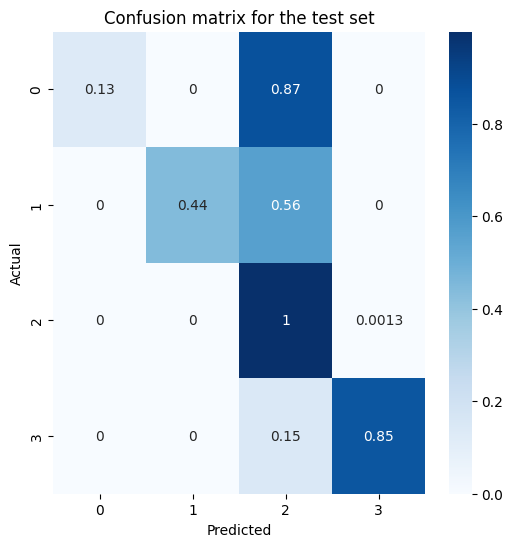

In [65]:
# random forest classification on the X_train, X_test, y_train, y_test datasets
from sklearn.ensemble import RandomForestClassifier

params = {
    'max_depth': 8,
    'criterion': 'gini',
    'n_estimators': 100,
    'random_state': 42
}

clf = RandomForestClassifier(**params)

pipeline = make_pipeline(
    StandardScaler(),
    clf
)

pipeline.fit(X_train, y_train["new_labels"])

preds = pipeline.predict(X_test)

print("Accuracy: ", accuracy_score(y_test["new_labels"], preds.round()))
print("Recall: ", recall_score(y_test["new_labels"], preds.round(), average="macro"))
print("F1: ", f1_score(y_test["new_labels"], preds.round(), average="macro"))
print("MCC: ", matthews_corrcoef(y_test["new_labels"], preds.round()))
print("Balanced accuracy: ", balanced_accuracy_score(y_test["new_labels"], preds.round()))

plot_confusion_matrix(y_test["new_labels"], preds.round(), title="Confusion matrix for the test set")

Random Forest has trouble with the multiclass classification.

### c. XGBoost

Accuracy:  0.991313789359392
Recall:  0.9719146905523034
F1:  0.9809451601636362
MCC:  0.9710264768715865
Balanced accuracy:  0.9719146905523034


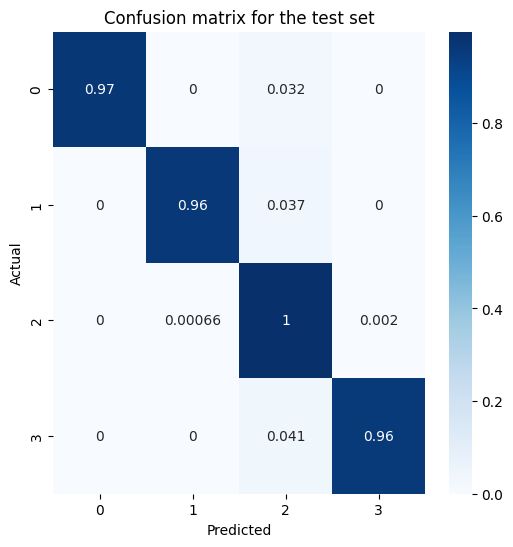

In [67]:
# xgboost classification on the X_train, X_test, y_train, y_test datasets
from xgboost import XGBClassifier

params = {
    'max_depth': 8,
    'n_estimators': 100,
    'random_state': 42
}

clf = XGBClassifier(**params)

pipeline = make_pipeline(
    StandardScaler(),
    clf
)

pipeline.fit(X_train, y_train["new_labels"])

preds = pipeline.predict(X_test)

print("Accuracy: ", accuracy_score(y_test["new_labels"], preds.round()))
print("Recall: ", recall_score(y_test["new_labels"], preds.round(), average="macro"))
print("F1: ", f1_score(y_test["new_labels"], preds.round(), average="macro"))
print("MCC: ", matthews_corrcoef(y_test["new_labels"], preds.round()))
print("Balanced accuracy: ", balanced_accuracy_score(y_test["new_labels"], preds.round()))

plot_confusion_matrix(y_test["new_labels"], preds.round(), title="Confusion matrix for the test set")

The XGBoost model is the best so far, with almost 97% Recall and 99% Accuracy.